In [12]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_softmax_stack = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_softmax_stack(x)
        return logits
    
# Prepare to load data in next sesction
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class PongDataset(Dataset):
    def __init__(self, X, y):
        self.features = X.values
        self.labels = y.values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

Using cuda device


In [13]:
#Load orcreate new model

model = NeuralNetwork().to(device)
model_path = 'my_model.pt'

if(os.path.exists(model_path)):
    model.load_state_dict(torch.load(model_path))
    print("Loaded saved state")

In [14]:

#load data from file
raw_data = pd.read_table('TrainingQueue.tsv')
play_data = raw_data.sample(frac=1, random_state=1)
#print("Printing raw_data: ", raw_data, '\n')
#print("Printing play_data: ", play_data)

#print("Printing play_data: ", play_data)
X = play_data.drop(['MyPaddleIsRight', 'MyPaddleIsLeft', 'MyPaddleIsStill', 'Unnamed: 11'], axis=1).dropna()
# y = play_data[['MyPaddleIsRight', 'MyPaddleIsLeft', 'MyPaddleIsStill']].dropna()
y = play_data[['MyPaddleIsRight', 'MyPaddleIsLeft', 'MyPaddleIsStill']].idxmax(axis=1).map({'MyPaddleIsRight': 0, 'MyPaddleIsLeft': 1, 'MyPaddleIsStill': 2}).dropna()


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create data loaders for the training and validation sets
train_dataset = PongDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = PongDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Epoch [0/100], Train Loss: -0.6874, Val Loss: -0.6927
Epoch [1/100], Train Loss: -0.6875, Val Loss: -0.6928
Epoch [2/100], Train Loss: -0.5000, Val Loss: -0.6928
Epoch [3/100], Train Loss: -0.6250, Val Loss: -0.6928
Epoch [4/100], Train Loss: -0.6875, Val Loss: -0.6928
Epoch [5/100], Train Loss: -0.7500, Val Loss: -0.6928
Epoch [6/100], Train Loss: -0.6875, Val Loss: -0.6928
Epoch [7/100], Train Loss: -0.7500, Val Loss: -0.6928
Epoch [8/100], Train Loss: -0.8125, Val Loss: -0.6928
Epoch [9/100], Train Loss: -0.8125, Val Loss: -0.6928
Epoch [10/100], Train Loss: -0.7499, Val Loss: -0.7036
Epoch [11/100], Train Loss: -0.6945, Val Loss: -0.7067
Epoch [12/100], Train Loss: -0.8125, Val Loss: -0.7076
Epoch [13/100], Train Loss: -0.8707, Val Loss: -0.7093
Epoch [14/100], Train Loss: -0.8584, Val Loss: -0.7099
Epoch [15/100], Train Loss: -0.8750, Val Loss: -0.7101
Epoch [16/100], Train Loss: -0.7714, Val Loss: -0.7104
Epoch [17/100], Train Loss: -0.7392, Val Loss: -0.7108
Epoch [18/100], Trai

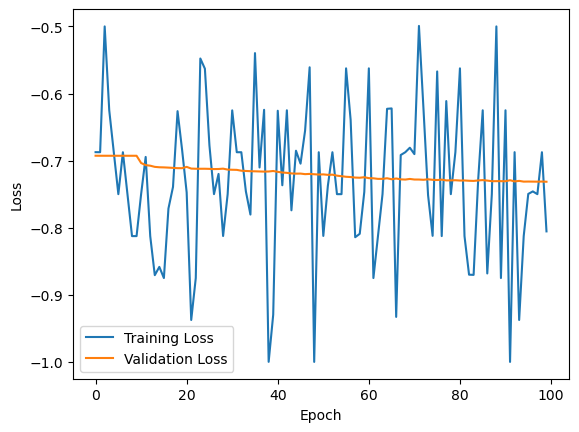

In [15]:
import matplotlib.pyplot as plt

# Define the binary loss function and optimizer
loss_fn = nn.NLLLoss()
learning_rate = .0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store the training and validation losses
train_losses = []
val_losses = []

# Train the model for the specified number of epochs
num_epochs = 100
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    for batch in train_loader:
        # Move the batch of training data to the device
        X_batch, y_batch = batch
        X_batch = X_batch.float()
        y_batch = y_batch.long()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # print("predicted:", y_pred, "real: ", y_batch, "loss: ", loss)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the validation set
    with torch.no_grad():
        val_loss_sum = 0
        num_batches = 0
        for batch in val_loader:
            # Move the batch of validation data to the device
            X_batch, y_batch = batch
            X_batch = X_batch.float()
            y_batch = y_batch.long()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(X_batch)
            val_loss = loss_fn(y_pred, y_batch)
            val_loss_sum += val_loss.item()
            num_batches += 1
            
        # Calculate the average validation loss for the epoch
        val_loss_avg = val_loss_sum / num_batches
        
        # Append the training and validation losses to their respective lists
        train_losses.append(loss.item())
        val_losses.append(val_loss_avg)
            
        # Print progress
        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss_avg:.4f}")

# Plot the training and validation loss curves
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [18]:
# Evaluate the trained model on the test set
model.eval()

test_loss = 0
correct = 0
with torch.no_grad():
    for batch in val_loader:
        # Move the batch of testing data to the device
        X_batch, y_batch = batch
        X_batch = X_batch.float()
        y_batch = y_batch.long()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        if isinstance(loss, tuple):
            test_loss += loss[0].item()
        else:
            test_loss += loss.item()

        # Compute number of correct predictions
        y_pred_class = torch.argmax(y_pred, dim=1)
        y_batch_class = y_batch
        correct += (y_pred_class == y_batch_class).sum().item()

test_loss /= len(val_loader.dataset)
accuracy = correct / len(val_loader.dataset)

print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2%}')



Test set: Average loss: -0.0457, Accuracy: 73.25%


In [19]:
# Export model
model.to('cpu')
onnx_file_name = "torch_model.onnx"
dummy_input = torch.randn(1,8)

# Export the trained model to ONNX format
torch.onnx.export(model,                 # model being run
                  dummy_input,           # dummy input tensor
                  onnx_file_name,        # output file name
                  verbose=True,          # print out a lot of information
                  input_names=["input"], # specify the name of the input
                  output_names=["output"], # specify the name of the output
                  opset_version=10)      # the ONNX version to use


torch.save(model.state_dict(), model_path)